In [206]:
from tiffConverter import convert_to_numpy
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import cv2
from helperFunctions import subpixel_shift

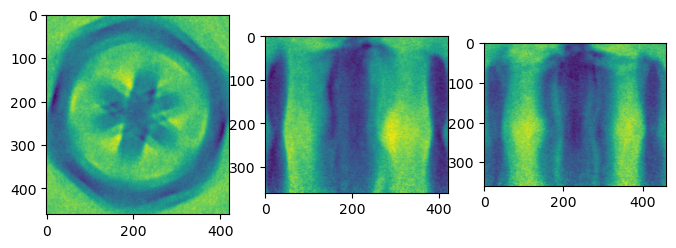

In [220]:
#Read in Kevin projection for reference
recon_location = "/Users/levih/Desktop/TomoMono/reconstructions/foamRecon_notNormalized_20240717-143914_gpu.tif"
tomo, tomo_scale_info = convert_to_numpy(recon_location)

#Dimensions for cropped image (used later for electron density)
fig1, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (8,8))
a, b = 160, 520
c, d = 220, 680
e, f = 240, 660
axs[0].imshow(tomo[260,c:d,e:f])
axs[1].imshow(tomo[a:b,450,e:f])
axs[2].imshow(tomo[a:b,c:d,450])
tomo = tomo[a:b, c:d, e:f]


ang = tomopy.angles(5, 0, 360) #First angle should theoretically be the same no matter how many angles I project through
tomopyProjections = tomopy.project(tomo, ang)

750
-18
61


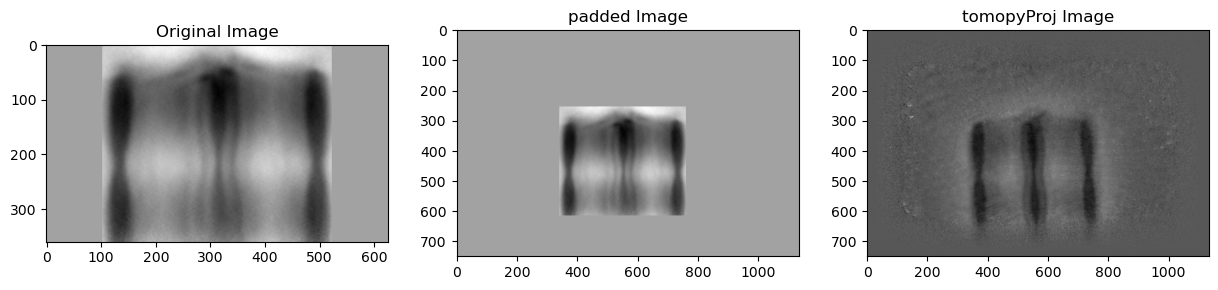

750
29
62


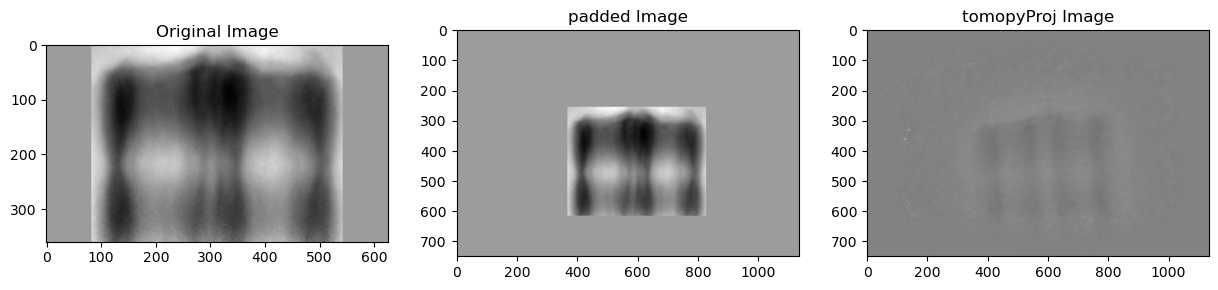

750
10
63


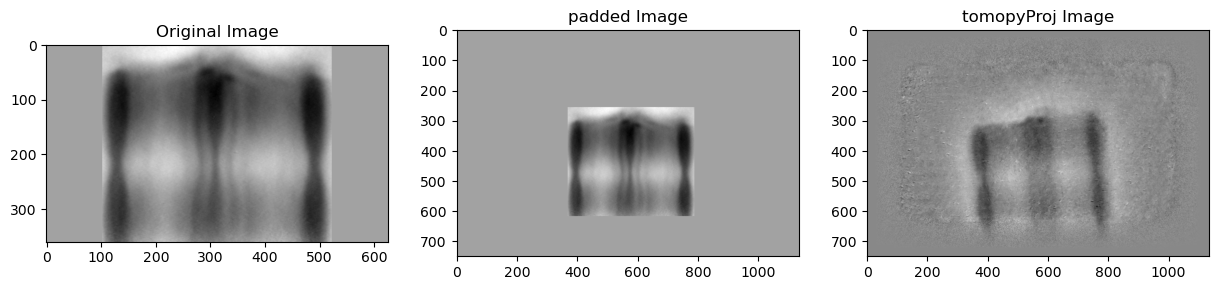

750
-18
55


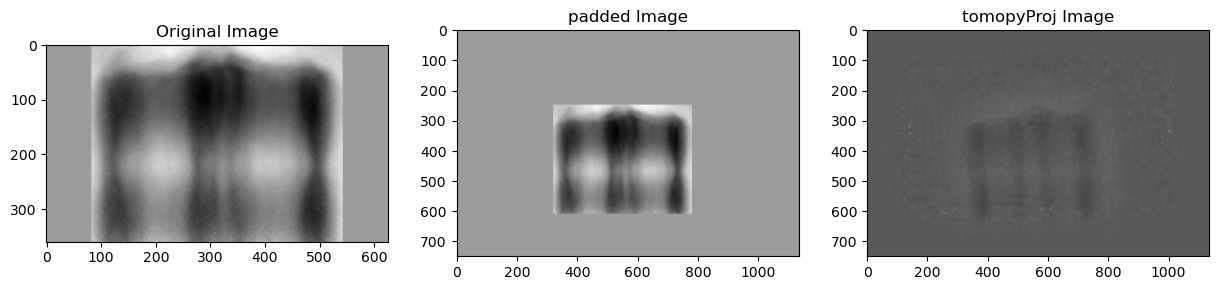

750
-46
63


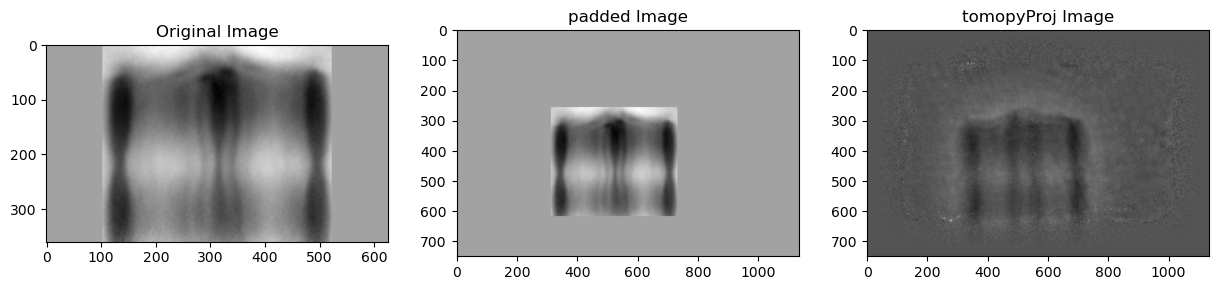

In [221]:
for i in range(5):
    aligned_proj_location = "/Users/levih/Desktop/TomoMono/data/fullTomoReconstructions2.tif"
    kevinProjections, kevin_proj_scale_info = convert_to_numpy(aligned_proj_location)
    kevinProjOriginal = kevinProjections[i*72]
    
    tomopyProjOriginal = tomopyProjections[i]

    padded_tomopyProj = padAndAlign(kevinProjOriginal, tomopyProjOriginal)

    # Plot original and shifted images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(tomopyProjOriginal, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("padded Image")
    plt.imshow(padded_tomopyProj, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("tomopyProj Image")
    plt.imshow(kevinProjOriginal, cmap='gray')
    plt.show()

In [222]:

def padAndAlign(kevinProj, tomopyProj):
    # Determine dimensions of the target projection (tomopyProj)
    target_h, target_w = kevinProj.shape
    source_h, source_w = tomopyProj.shape
    delta_x = (target_w-source_w)//2
    delta_y = (target_h-source_h)//2

    print(target_h)

    # Apply padding to align with tomopyProj
    padded_tomopyProj = np.pad(
        tomopyProj,
        ((delta_y, delta_y), (delta_x, delta_x)),
        mode='constant',
        constant_values=0
    )
    
    # Find the best match location for alignment
    res = cv2.matchTemplate(kevinProj.astype(np.float32), tomopyProj.astype(np.float32), cv2.TM_CCOEFF_NORMED)
    loc = np.where(res == res.max())
    pt = list(zip(*loc[::-1]))[0]
    
    # Calculate shifts and the necessary padding/cropping
    shift_x = pt[0] - delta_x
    shift_y = pt[1] - delta_y

    
    print(shift_x)
    print(shift_y)
    return subpixel_shift(padded_tomopyProj, shift_y, shift_x)

In [225]:
#Read in Kevin projection for reference
recon_location = "/Users/levih/Desktop/TomoMono/reconstructions/foamRecon_notNormalized_20240717-143914_gpu.tif"
tomo, tomo_scale_info = convert_to_numpy(recon_location)

ang = tomopy.angles(20, 0, 360) #First angle should theoretically be the same no matter how many angles I project through
tomopyProjections = tomopy.project(tomo, ang)

# shifted_values = np.load('shiftValues_TIMESTAMP.npy')
shifted_values = np.ones((tomopyProjections.shape[0],2))*20

def createDatasetForTory(dataset, shifted_values, kevin_x, kevin_y):
    delta_x = (kevin_x - 900)/2
    delta_y = (kevin_y - 550)/2

    delta_x2 = (900-512)//2
    delta_y2 = 550-402
    tomo.crop_bottom_center(402, 512)

    newDataset = np.zeros_like(dataset)

    for i in range(dataset.shape[0]):
        # Apply padding to align with tomopyProj
        padded_tomopyProj = np.pad(
            tomopyProj,
            ((delta_y+delta_y2, delta_y), (delta_x + delta_x2,delta_x + delta_x2)),
            mode='constant',
            constant_values=0
        )

        newDataset[i] = subpixel_shift(padded_tomopyProj, shifted_values[i,0], shifted_values[i,1])

    return newDataset


In [226]:
createDatasetForTory(tomopyProjections, shifted_values, 1134, 750)

AttributeError: 'numpy.ndarray' object has no attribute 'crop_bottom_center'